In [72]:
import urllib
from sqlalchemy import create_engine

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date, timedelta
from time import time
import numpy as np

from sklearn.cluster import KMeans
import scipy.cluster.hierarchy as shc
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering

from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.utils import shuffle

Very_Start = time()

### DEFINITION DE TOUS LES PARAMETRES

In [73]:
# @param Save Figure
save_fig    = False      # If True : Save the figure that are plot ; If show_fig == False, figure won't be save 
save_folder = 'UC2_fig'  # Folder where the figure is saved

# All stuffs for the connection to the DB
driver= '{ODBC Driver 17 for SQL Server}'
server = 'dlt-bi.database.windows.net'
username = 'WVN-TEST'
database = 'Export Data Prod' #'DelitraiteurBI_Prod'
password = 'jYei0u22cGZiE9F4VFER'
login = ('DRIVER=' + driver + 
         ';SERVER=' + server + 
         ';PORT=1433;DATABASE=' + database + 
         ';UID=' + username + 
         ';PWD=' + password)

driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

schema_Fact = 'ARC'
schema_Dim  = 'PML'

# @param DB / Table / Column Name   -> Should be changed if you change DB
"""
    Il faut ici récupérer tous les articles vendus au même consommateur.
    Pour ça, on va récupérer la clé primaire du consommateur, contenu dans [Entete_Ticket.CONSOMMATEUR.KEY].
    Le contenu du ticket est dans la table de détail du ticket : [Detail_Ticket.Article.KEY].
    
    Les tables détail et entête ne sont pas liés par des clés étrangère.
    Pour les liés, il faut que la date ET le numéro de ticket.
    
    Pour ne pas perdre le sens des articles dans l'analyse, on utilise leur groupement par univers.
    Ces univers sont composés de 4 niveau de précision (1 étant le moins précis avec 16 univers, 4 étant le plus précis avec 490 univers).
    Cette précision peut être modifier avec la variable @Univers_Depth.
"""
DB             = database    
TABLE_CONSO    = "Consommateur"
TABLE_ENTETE   = "Recette_entete_ticket"
TEMPS_ENTETE   = TABLE_ENTETE             + ".TEMPS.KEY_Date_reel_de_la_transaction"
NUMERO_ENTETE  = TABLE_ENTETE             + ".Numero_ticket"
TABLE_DETAIL   = "Recette_detail_ticket"
TEMPS_DETAIL   = TABLE_DETAIL             + ".TEMPS.KEY_Date_reel_transaction"
NUMERO_DETAIL  = TABLE_DETAIL             + ".Numero_ticket"
TABLE_ARTICLE  = "Article_meti_HIST"
TABLE_UNIVERS  = "Univers"

In [74]:
# TEST Connexion
params = urllib.parse.quote_plus(login)
engine = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

conn = engine.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_UNIVERS+".KEY] FROM ["+DB+"].["+schema_Dim+"].[Dim_"+TABLE_UNIVERS+"]", conn)
print(df)

conn.close()

   Univers.KEY
0           -1
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9


# DEFINITION DES FONCTIONS

### Pretraitements des données

In [75]:
"""
    Les Articles sont regroupés en univers.
    Les Univers possèdent 4 niveau de profondeur/précision.
    Plus la profondeur est élevés, plus il y a d'univers et plus c'est précis.
        Univers_Depth = 1 => #Univers = 16
        Univers_Depth = 4 => #Univers = 490
    
    Deux univers sont commun à N niveau près si leur N premier libellé sont commun.
    Pour obtenir les univers d'une ceraines profondeurs, on regarde alors les libellés distincts.
    
    
        @ Input : 
            - Univers_Depth [int] = [1;4]
                Niveau de profondeur jusqu'où aller
        
        @ Ouput : 
            - Univers Correspondance [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Dictionnaire permettant de savoir quel univers correspond à un autre pour un certain degré de profondeur.
                L'univers Univers_Key devient Univers_Key_Correspondance pour une profondeur Univers_Depth
        
"""
def get_univers_correspondance(Univers_Depth):
    #SQL Request to select Key + 4 level of libelle of the table Dim_Univers
    sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY],
        [''' + TABLE_UNIVERS  + '''.Libelle_univers1_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR], 
        [''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR]
        FROM ['''+DB+'''].['''+schema_Dim+'''].[Dim_'''+TABLE_UNIVERS+''']'''

    #Connexion to DB and load DataFrame
    conn = engine.connect()
    df_univers = pd.read_sql(sql_command, conn)
    conn.close()

    #Variable to return
    univers_correspondance = {}
    #Stocks Univers key which is deleted.
    deleted = set()
    
    """
        Double boucle, on vérifie pour l'univers 1 si il existe des univers commun,
        puis sur l'univers 2 si il n'est pas supprimé, 
        puis sur le 3, etc.
    """
    for item in df_univers.values:
        if item[0] in univers_correspondance.keys():
            continue
        univers_correspondance[item[0]] = item[0]
        for cor in df_univers.values: 
            # If libelle 1 to Univers_Depth of both univers are the same, they are the same
            if item[0] != cor[0] and (
                item[1] == cor[1] and
                (item[2] == cor[2] or Univers_Depth < 2) and
                (item[3] == cor[3] or Univers_Depth < 3) and
                (item[4] == cor[4] or Univers_Depth < 4)
            ):
                univers_correspondance[cor[0]] = item[0]
        
    return univers_correspondance

In [76]:
"""
    Transforme de dataframe load par la commande SQL sous forme d'un dataframe avec :
        - les client.KEY en index et les univers.KEY en column
        - le nombre de fois que le client à acheter l'univers en values
    
    Les clients effectuant trop peu d'achat sont exclu du dataframe d'output.
    Les values sont également normalisée MINMAX selon les rows si la normalisation standard n'est pas choisie.
    
        @ input :
            - dataframe [pd.DataFrame] 
                données récupérée par la query SQL. Doit contenir la clé client et la clé univers.
            - univ_cor [dict] = {(Univers_Key : Univers_Key_Correspondance)}
                Correspondance des univers en fonction de la profondeur utilisée.
                output de la fonction get_univers_correspondance(Univers_Depth)
            - COLUMN_CONSO 
                Nom de la colonne contenant les clé consommateur
            - COLUMN_UNIVERS
                Nom de la colonne contenant les clé univers
            - client_tresh
                seuil de pertinence pour garder un client. On exclu un client qui a fait moins d'achat que client_tresh.
            - Standard_Norm
                Est-ce qu'on effectue une normalisation standard ou pas ? 
"""
def get_client_achat(dataframe, univ_cor, COLUMN_CONSO, COLUMN_UNIVERS, client_tresh, Standard_Norm = False):
    start = time()
    
    nbr_data = len(dataframe.values)
    
    dict_client_univ = {}

    # look in all data of dataframe
    for i in range(nbr_data):
        univ   = dataframe[COLUMN_UNIVERS][i]
        client = dataframe[COLUMN_CONSO][i]
        
        # We exclude univers.KEY = -1 (can also be done in SQL Query)
        if univ == -1:
            continue

        # get univers_correspondance of univ
        if univ in univ_cor.keys():
            univ = univ_cor[univ]
        
        # Ajoute les colomn/index au dictionnaire si elles ne sont pas présentes dedans
        if not client in dict_client_univ:
            dict_client_univ[client] = {}
        if not univ in dict_client_univ[client]:
            dict_client_univ[client][univ] = 0
        
        # Augment de 1 le nombre d'achat de l'univers effectuer par le client
        dict_client_univ[client][univ] += 1

    # On exclu les client sous le seuil, on normalise les autres.
    to_remove = []
    for k,v in dict_client_univ.items():
        # Si le client est sous le seuil, on l'exclura après
        if sum(v.values()) < client_tresh:
            to_remove.append(k)
        # Si le client est au dessus du seuil, on normalise sa ligne
        elif not Standard_Norm:
            maxi = max(v.values())
            dict_client_univ[k] = {key:value/maxi for key,value in v.items()}

    # Exclusion des clients qui ont été marqués
    for k in to_remove:
        del dict_client_univ[k]

    # Transformation des données sous formes de DataFrame
    clients_data = pd.DataFrame(index = dict_client_univ.keys(),
                            data = dict_client_univ.values())
    clients_data = clients_data.replace(float('NaN'), 0)

    # environ 10s * nbr_client/10.000
    print("Time Taken to load Dataframe: ~" + str(int(time() - start)) + "secondes")

    return clients_data

In [77]:
"""
    Fonction de normalisations du dataframe.
    Normalize selon les colonnes.
    
    Deux types de normalisation sur un ensemble {x_i}: 
        - Standard : x -> (x-µ)/σ 
            avec µ == moyenne de la colonne    | µ  = sum(x_i)/N
                 σ == écart type de la colonne | σ² = sum((x_i-µ)²)/N
        - MinMax   : x -> x / (max(x_i) - min(x_i))
        
    Les scalers peuvent être inversé mais ce n'est pas utile ici.
    Les librairie de scaler font toutes la normalisation automatiquement.
    Sinon de simple boucle avec les équations ci-dessus permettent d'obtenir le même résultats.
    
        @ input : 
            - df [pd.DataFrame]
                Données à normaliser
        
        @ output : 
            - normalized_df [pd.DataFrame]
                df normalisé
"""
# Standard Normalization
def standard_normalization(df):
    scaler = StandardScaler()
    scaled_values = scaler.fit_transform(df)
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

# Min-Max Normalization
def minmax_normalization(df):
    scaler = MinMaxScaler() 
    scaled_values = scaler.fit_transform(df) 
    return pd.DataFrame(index = df.index, columns = df.columns,data = scaled_values)

### Analyse des algorithmes sur les données 

In [78]:
"""
    Trace l'Elbow curve.
    L'Elbow curve est une courbe permettant de montrer la distance totale entre tous les cluster et les habitants de ce cluster.
    Cette distance est ce qui est miniser dans l'algorithm KMeans.
    
    Sa forme de bras coudé lui vaut son nom. En général, le bon nombre de cluster se trouve justement au coude.
    Sauf que souvent dans des cas réel avec beaucoup de données et de dimensions, et des clusters non-clairement identifié,
        L'elbow curve prend la forme d'une exponentiel à coefficient négatif.
    Il est donc complexe de déduire un nombre optimal de cluster.
    
    Pour plus d'info sur l'Elbow Curve, je redirigerais vers ce lien qui explique les bases du clustering et de l'Elbow :
        https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/
        
        @ input : 
            - dataframe [pd.DataFrame] 
                Données à clusteriser
            - Kmin [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
            - KMax [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
                
        @ output :
            - None
"""
def Elbow(dataframe, Kmin = 1, Kmax = 30):
    start = time()
    
    # Store the value of total distance
    distorsions = []
    # Run KMeans Algorithm for k number of cluster with k = [KMin;Kmax[ [int]
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        model = KMeans(n_clusters=k)
        model.fit(dataframe)
        distorsions.append(model.inertia_)

    # Plot the Elbow Curve
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Elbow_Curve.jpg")
    
    plt.show()
    # environ 10s*Kmax
    print("Time Taken to generate Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [79]:
"""
    Comme dis au-dessus, l'Elbow curve n'est pas parfaite pour déterminer le nombre de cluster lorsqu'ils sont peu identifiable.
    Une autre courbe a alors été immaginés par moi même : l'Exclude Elbow Curve.
    
    Le but de ce usecase étant la segmentation de clientèle, il est alors intéressant de voir si les client s'intéresse au produit.
    Un segment qui nous dis que les clients ne s'intéresse à rien en particulier n'est pas très intéressant.
    Ce segment est cependant inévitable, certains client ont des comportement qui peuvent être qualifier d'"étrange".
    On va cependant essayer de minimiser la taille de ce segment.
    Ce segment est plus petit quand le nombre de cluster est grand.
    Mais il ne faut pas avoir trop de cluster sinon on risque l'overfitting. 
    
    L'Exclude Elbow Curve se base alors sur le même principe que l'Elbow cure,
        sauf qu'elle trace ici la proportion de client dans le segment que l'ont peut qualifier de "Null" en fonction du nombre de Cluster.
    Son allure est un peu similaire à l'Elbow curve, d'où son nom.
    
    Cette courbe a un autre avantage, elle marche quelque soit l'algorithm utilisé pour clusterisé.
    Cependant, la courbe a potentiellement moins de sens réel que l'Elbow curve, et nécessite en plus un treshold subjectif,
    treshold a partir duquel un cluster considérera qu'une caractéristique de son centre est intéressante.
    
        @ input : 
            - dataframe [pd.DataFrame] 
                Données à clusteriser
            - Kmin [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
            - KMax [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
            - treshold [float]
                seuil a partir duquel une caractéristique est jugé intéressante.
                Ce seuil dépend de la normalisation utilisée sur les données
            - method [str] = ["ward", "complete", "average", "single"]
                méthode utilisé dans l'algorithme hierarchical clustering
            - Algo [str] = ["KMeans", "hierarchical"]
                Algorithme à analyser
                
        @ output :
            - None
"""
def Exclude_Elbow(dataframe, Kmin, Kmax, treshold, method = 'ward', Algo= 'KMeans'):
    start = time()

    # Store the value of proportion of poeple in the Null cluster(s)
    distorsions = []
    for k in range(Kmin, Kmax):
        print(k, end = ' ')
        #identify algorithm and fit the corresponding model
        if Algo == 'KMeans':
            model = KMeans(n_clusters=k)
        elif Algo == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=k, affinity='euclidean', linkage=method)
        else:
            print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
            return
        
        
        model.fit(dataframe)
        cluster = model.labels_
        
        # Get the centers of the clusters
        if Algo == 'KMeans':
            cluster_centers = model.cluster_centers_
        elif Algo == 'hierarchical':
            cluster_centers = get_centroid(dataframe, cluster)
            cluster_centers = [cc.values() for cc in cluster_centers]
        
        # Get the proportion of poeple in the Null cluster(s), where no value in the center is > treshold
        NACK = 0
        for i in range(len(cluster_centers)):
            if sum([(1 if c > treshold else 0) for c in cluster_centers[i]]) == 0:
                NACK += cluster.tolist().count(i)

        distorsions.append(NACK/len(cluster))
    
    # Plot the exclude Elbow Curve
    fig = plt.figure(figsize=(15, 5))
    plt.plot(range(Kmin, Kmax), distorsions)
    plt.grid(True)
    plt.title('Exclude Elbow curve')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Exclude_Elbow_Curve.jpg")
    
    plt.show()
    

    # environ 10s*Kmax
    print("Time Taken to generate Exclude Elbow Curve : ~" + str(int(time() - start)) + "secondes")

In [80]:
"""
    Trace le dendrogram.
    Les Dendrogram sont la visualisation des distances des clusters dans le cadre d'un Algorithm HierarchicalCluster.
    Ils permettent d'identifier le nombre de cluster optimal.
    Pour plus d'info : 
        https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8
    
            @ input : 
            - dataframe [pd.DataFrame] 
                Données à clusteriser
            - method [str] = ["ward", "complete", "average", "single"]
                méthode utilisé dans l'algorithme hierarchical clustering
                
        @ output :
            - None
"""
def Dendrogram(dataframe, mehtod = 'ward'):
    start  = time()
    
    plt.figure(figsize=(15, 7))  
    plt.title("Dendrograms")  
    
    # Load & plot the Dendogram
    dend = shc.dendrogram(shc.linkage(dataframe, method=method), p = 50, truncate_mode = 'level')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_Dendrogram_"+method+".jpg")
    plt.show()


    # Enivron 250s*(client/10000)²
    print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

In [81]:
"""  
    Fonction générale d'Analyse des données et des algorithm de clusterisation.
    Va run toutes les fonctions vues précédemment pour permettre d'interpréter les résultats.
    
        @ input : 
            - dataframe [pd.DataFrame] 
                Données à clusteriser
            - treshold [float]
                seuil a partir duquel une caractéristique est jugé intéressante.
                Ce seuil dépend de la normalisation utilisée sur les données
            - Kmin [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
            - KMax [int] >= 1
                A partir de quel nombre de cluster commence-t-on à tracer la courbe 
            - method [str] = ["ward", "complete", "average", "single"]
                méthode utilisé dans l'algorithme hierarchical clustering
            - Algo [str] = ["KMeans", "hierarchical"]
                Algorithme à analyser
                
        @ output :
            - None
"""
def Analysis(dataframe, treshold, Kmin=5, Kmax=30, method = 'ward', Algo= 'KMeans'):
    if Algo == 'KMeans':
        Elbow(dataframe, Kmin, Kmax)   
    elif Algo == 'hierarchical':
        Dendrogram(dataframe, mehtod = method)
    else:
        print("Wrong Algo as input : choose beetween 'KMeans' or 'hierarchical'")
        return
    Exclude_Elbow(dataframe, Kmin, Kmax, treshold, method, Algo)

In [82]:
"""
    Va regarder la proportion de données gardées dans le cas d'une diminution de dimension par algorithm PCA.
    L'alogirthm PCA réduit un espace de dimension M en un espace de dimension N < M de manière a gardé un maximum d'information.
    
    Pour utiliser le clustering avec du PCA, il vaut mieux essayer de conserver ~80% de l'information. 
    PCA peut conserver autant d'information en divisant d'un ordre de 10 les dimensions, 
        ce qui peut grandement améliorer les performances d'un algorithme.
        
        @ input : 
            - dataframe [pd.DataFrame] 
                Données à clusteriser
                
        @ output :
            - None
"""
def PCA_Analysis(dataframe):
    max_analyzed_dim = len(dataframe.columns)
    
    # Create a PCA model with all dimension of dataframe
    model_pca = PCA(n_components= max_analyzed_dim)
    predict = model_pca.fit(dataframe).transform(dataframe)
    
    # Calculate the value of information lost for dimension frome 1 to i
    total_coef = {i:1-sum(model_pca.explained_variance_ratio_[:i]) 
                  for i in range(max_analyzed_dim)}
    
    # plot information lost in fonction of dimension kept.  
    plt.figure(figsize=(15, 7)) 
    plt.plot(total_coef.keys(), total_coef.values())
    plt.grid(True)
    plt.title('PCA Reduction : Quantitée Relative Perdue en fonction du nombre de dimension')
    
    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Reduction_Proportion.jpg")
    
    plt.show()


In [83]:
"""
    Plot les données réduite à deux/trois dimension pour un meilleur visuel.
    La fonction peut également plot les centres des clusters calculées par les différents algorithme.
    Elle colorie alors chaque point appartenant au même cluster par une même couleur.
    
        @ input : 
            - data [pd.DataFrame] 
                Données à plot
            - target [list(int))]
                Cluster associé à chaque point des données.
                len(target) == len(data.values)
            - centroid [list(list(float))]
                Centre de chaque cluster
            - method [str]
                méthode utilisé pour la clusterisation. Présente uniquement dans le nom du graphique à sauvegarder.
            - threeD [boolean]
                Si True, alors on fait le PCA en 3D et en 2D
                
        @ output :
            - None
"""
def PCA_Visualisation(data, target=[], centroid=[], method = "", threeD = False):
    start = time()

    model_pca = PCA(n_components= 2)
    predict = model_pca.fit(data).transform(data)
    
    print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))
    
    plt.figure(figsize=(15, 7))  
    if list(target):
        plt.scatter(predict[:,0],predict[:,1], c=target, alpha=.8)
    else: 
        plt.scatter(predict[:,0],predict[:,1])
    if list(centroid):
        clust_predict = model_pca.transform(centroid)
        plt.scatter(clust_predict[:,0],clust_predict[:,1], color='r')
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    plt.title('PCA of dataset - ' + method + ' - Cluster = ' + str(K))

    if save_fig:
        plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster-"+str(K)+"-"+method+".jpg")
    
    if threeD:
        model_pca = PCA(n_components= 3)
        predict = model_pca.fit(data).transform(data)
        print('Explained variance ratio from PCA: {}'.format(model_pca.explained_variance_ratio_))


        plt.figure(figsize=(30, 30)) 
        ax = plt.axes(projection='3d')

        ax.scatter3D(predict[:,0], predict[:,1], predict[:,2], c=target);

        plt.title('PCA of dataset in 3D - ' + method)

        if save_fig:
            plt.savefig(save_folder+"/"+str(Univers_Depth)+"_PCA_Cluster_3D-"+str(K)+"-"+method+".jpg")
    
    # environ 1.5s
    print("Time Taken to show PCA : ~" + str(int(time() - start)) + "secondes")

## Obtention des données intéressantes

In [84]:
"""
    Get for eache cluster_centers the keys of the center where the values are > treshold
    
        @ input : 
            - cluster_center [list(dict)] = list({univers_key : power})
                center of all the cluster calculate by the algorithm
            - treshold [float]
                threshold where the value are kept if above
        
        @output : 
            - interset [dict] = {(cluster_key : list(int = univ_key))}
                for each cluster, a list of the universe where there power are above treshold
"""
def get_interest(cluster_center, treshold):
    interest = {i:[] for i in range(len(cluster_center))}

    # Check for each cluster
    for i in range(len(cluster_center)):
        # Check for each dimension
        for key,val in cluster_center[i].items():
            if val > treshold:
                interest[i].append(key)
                
    return interest

In [85]:
"""
    Affiche les interest avec leur libellé plutot que les interest avec les clés d'univers.
    Prend en compte la profondeur d'univers.
    
    Affiche pour chaque cluster la proportion d'habitant de ce cluster.
    Affiche pour chaque intéret la puissance de l'intérêt. Les intéret sont sort par cette puissance. 
    
        @ input : 
            - conn
                connexion au serveur sql
            - interset [dict] = {(cluster_key : list(int = univ_key))}
                for each cluster, a list of the universe where there power are above treshold
            - cluster [list(int)]
                Contain for each custommer the cluster assign to this custommer 
            - cluster_center [list(dict)] = list({univers_key : power})
                center of all the cluster calculate by the algorithm
        
        @ output :
            None
"""
def print_interest(conn, interest, cluster, cluster_centers):
    NACK = 0

    conn = engine.connect()
    for key,values in interest.items():
        val = sorted(values)
        
        print("\n\nCluster", key, end=': ')
        proportion = cluster.tolist().count(key)*100/len(cluster)
        print(round(proportion,2),"%",)

        if len(values) == 0:
            NACK += proportion
            continue

        sql_command = '''SELECT [''' + TABLE_UNIVERS  + '''.KEY] AS Univ_KEY, 
        ['''  + TABLE_UNIVERS  + '''.Libelle_univers1_FR] AS Univ_1 ''' + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers2_FR] AS Univ_2 ''')*int(Univers_Depth >= 2) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers3_FR] AS Univ_3 ''')*int(Univers_Depth >= 3) + ('''
        ,[''' + TABLE_UNIVERS  + '''.Libelle_univers4_FR] AS Univ_4 ''')*int(Univers_Depth >= 4) + '''
        FROM ['''+DB+'''].['''+schema_Dim+'''].[Dim_'''+TABLE_UNIVERS+''']
        WHERE '''
        for v in val:
            sql_command += "[" + TABLE_UNIVERS  + ".KEY] = " + str(v) + "\nOR "
        sql_command = sql_command[:-3]
        
        df_libele = pd.read_sql(sql_command, conn)

        df_libele["Power"] = [round(cluster_centers[key][i],2) for i in val]
        
        print(df_libele.sort_values("Power", ascending=False).to_string(index=False))
    conn.close()

    print("\nNACK =", round(NACK,2),"%")
    return round(NACK,2)

In [86]:
"""
    En fonction de chaque habitant du cluster, calcule le centre de ce cluster. 
    Pour ça, on prend la moyenne de tous les habitants du cluster.
    
        @ input :
            - dataframe [pd.DataFrame]
                Contain all custommer data
            - cluster [list(int)]
                Contain for each custommer the cluster assign to this custommer
        
        @ output :
            - cluster_center [list(dict)] = list({univers_key : power})
                center of all the cluster that were input
"""
def get_centroid(dataframe, cluster):
    nbr_cluster = len(set(cluster))
    cluster_center = [{c:0 for c in dataframe.columns} for _ in range(nbr_cluster)]
    proportion     = [0 for _ in range(nbr_cluster)]
    
    for i in range(len(cluster)):
        # Add all value of person in a cluster
        for c in dataframe.columns:
            cluster_center[cluster[i]][c] += dataframe[c][dataframe.index[i]]
        proportion[cluster[i]]  += 1
        
    # divide value of the center by the total number of poeple in the cluster
    for i in range(nbr_cluster):
        for c in dataframe.columns:
            cluster_center[i][c] /= proportion[i]
            
    return cluster_center

# SELECT et prétraitements des données

In [143]:
"""
    L'idéal, pour éviter d'avoir trop de similitude entre les segments de clientèle, Univers_Depth est mis à 3.
    Diminuer Univers_Depth impliquera aussi de diminuer le nombre de cluster K pour de meilleur résultat.
"""
Univers_Depth  = 3               # Jusqu'où on ira dans l'univers ? = [1;4]
year           = 2020            # Années où faire la segmentation
take_fidelity  = False

# @param Variable influançant la sélection des données
client_tresh   = 10           # Nombre d'article que le client doit avoir acheter pour être mis dans un segment
univers_tresh  = 50           # Nombre d'article acheté de l'univers pour qu'il soit pris en compte

# @param Sur la normalization des données
Standard_Norm  = False        # Défini si on utilise la Normalization Standard
Standard_Tresh = 1            # Seuil d'acceptabilité des cluster en normalization standard
MinMax_Norm    = True         # Défini si on utilise la Normalization Minmax
MinMax_Tesh    = .3           # Seuil d'acceptabilité des cluster par défaut

# @param Sur le modèle KMean
K              = 11            # Nombre de segment. K = 21 -> 10% client d'exclu ; K = 15 -> 15% client exclu ; K = 9 -> 20% exclu 
n_init         = 100           # Nombre de run du KMean pour trouver le meilleur min

# @param Sur l'analyse des données
do_Analysis    = False        # Est-ce qu'on fait l'analyse des Elbow ou pas ?
Kmin           = 5            # Nombre de cluster au début de l'analyse
Kmax           = 30           # Nombre de cluster à la fin de l'analyse


# @param Hierchaical/Agglomerative Clustering
max_fitted = 10000
method     = 'ward'            # types de méthode: ward complete average single
 
# @param PCA
threeD         = False         # Afficher le graphe 3D dans les projection PCA
nbr_dim_keep   = 10            # Nombre de dimension gardée lors du KMeans effectué après un PCA    
K_PCA          = K             # K pour KMeans après le PCA

In [144]:
start = time() 

"""
    La première commande SQL sélectionne tous les articles achetés par un client.
    Elle permet de faire une segmentation de clientèle. 
    
    La deuxième sélectionne tous les articles achetés dans une même transactions.
    Elle permet de faire une segmentation des tickets. 
"""
sql_command = '''SELECT
['''  + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
,[''' + TABLE_ENTETE  + '''.''' + TABLE_CONSO   + '''.KEY] AS ''' + TABLE_CONSO   + '''
FROM  ['''      + DB + '''].[ARC].[Fact_''' + TABLE_DETAIL + ''']
INNER JOIN [''' + DB + '''].[ARC].[Fact_''' + TABLE_ENTETE + '''] 
ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
INNER JOIN [''' + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
ON ['''    + TABLE_DETAIL  + '''.'''    + TABLE_ARTICLE  + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
WHERE [''' + TABLE_ENTETE  + '''.'''    + TABLE_CONSO    + '''.KEY] > 0 
AND   [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS  + '''.KEY] != 388
AND   [''' + TEMPS_DETAIL  +'''] > '''  + str(year*10000) +'''
AND   [''' + TEMPS_DETAIL  +'''] < '''  + str((year+1)*10000)


if not take_fidelity:
    sql_command = '''SELECT TOP(''' + str(nbr_data) + ''')
    [''' + TABLE_ARTICLE + '''.''' + TABLE_UNIVERS + '''.KEY] AS ''' + TABLE_UNIVERS + '''
    ,[''' + TABLE_ENTETE + '''.KEY] AS ''' + TABLE_CONSO + '''
    FROM  ['''      + DB + '''].[DWH].[Dim_'''  + TABLE_ARTICLE + ''']
    INNER JOIN [''' + DB + '''].[ARC].[Fact_''' + TABLE_DETAIL + ''']
    ON ['''    + TABLE_DETAIL  + '''.''' + TABLE_ARTICLE + '''.KEY] = [''' + TABLE_ARTICLE + '''.KEY] 
    INNER JOIN [''' + DB + '''].[ARC].[Fact_''' + TABLE_ENTETE + '''] 
    ON    [''' + TEMPS_DETAIL  +'''] = [''' + TEMPS_ENTETE  + '''] 
    AND   [''' + NUMERO_DETAIL +'''] = [''' + NUMERO_ENTETE + ''']
    WHERE [''' + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != -1 
    AND ['''   + TABLE_ARTICLE + '''.'''    + TABLE_UNIVERS + '''.KEY] != 388
    AND   [''' + TEMPS_DETAIL  +'''] > '''  + str(year    *10000) +'''
    AND   [''' + TEMPS_DETAIL  +'''] < '''  + str((year+1)*10000)

if DB == 'Export Data Prod':
    sql_command = '''
        SELECT [Article_meti_HIST.Univers.KEY] AS ''' + TABLE_UNIVERS + '''
      ,[Recette_entete_ticket.KEY]
      ,[Recette_entete_ticket.Consommateur.KEY] AS ''' + TABLE_CONSO + '''
      FROM [Export Data Prod].[PML].[Dim_detail_ticket]
      WHERE ['''   + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != -1 
        AND ['''   + TABLE_ARTICLE + '''.'''     + TABLE_UNIVERS   + '''.KEY] != 388
        AND   [''' + TEMPS_ENTETE  +'''] > '''  + str(year    *10000) +'''
        AND   [''' + TEMPS_ENTETE  +'''] < '''  + str((year+1)*10000)
    
print(sql_command)

conn = engine.connect()
df_univers = pd.read_sql(sql_command, conn)
conn.close()

# environ 5min
print("Time Taken to load DB: ~" + str(int(time() - start)) + "secondes") 
nbr_data = len(df_univers)
print(nbr_data)



        SELECT [Article_meti_HIST.Univers.KEY] AS Univers
      ,[Recette_entete_ticket.KEY]
      ,[Recette_entete_ticket.Consommateur.KEY] AS Consommateur
      FROM [Export Data Prod].[PML].[Dim_detail_ticket]
      WHERE [Article_meti_HIST.Univers.KEY] != -1 
        AND [Article_meti_HIST.Univers.KEY] != 388
        AND   [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] > 20200000
        AND   [Recette_entete_ticket.TEMPS.KEY_Date_reel_de_la_transaction] < 20210000
Time Taken to load DB: ~136secondes
29028221


In [145]:
univers_correspondance = get_univers_correspondance(Univers_Depth)
# Get data in a dataframe with client as index and univers as column
clients_data = get_client_achat(df_univers, univers_correspondance, TABLE_CONSO, TABLE_UNIVERS, client_tresh, Standard_Norm)
print(clients_data.head(10))

Time Taken to load Dataframe: ~332secondes
              154       41        407       86        45        81        408  \
-1       0.051225  0.027823  0.024881  0.015256  0.041939  0.005472  0.078805   
 47900   0.111111  0.000000  0.000000  0.000000  0.000000  0.000000  0.111111   
 1835    1.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 102411  0.225352  0.000000  0.014085  0.014085  0.042254  0.000000  0.070423   
 95855   0.285714  0.000000  0.000000  0.000000  0.142857  0.000000  0.428571   
 68872   0.066667  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
 43849   0.123457  0.000000  0.000000  0.000000  0.024691  0.000000  0.000000   
 58520   0.111111  0.000000  0.022222  0.011111  0.022222  0.011111  0.011111   
 8510    0.222222  0.027778  0.027778  0.000000  0.027778  0.000000  0.194444   
 31286   0.020202  0.030303  0.030303  0.030303  0.030303  0.000000  0.050505   

              151       92        294  ...       167       268   

In [146]:
# Normalized the data
norm_clients_data = clients_data.copy()

if Standard_Norm:
    norm_clients_data = standard_normalization(norm_clients_data)
# if MinMax_Norm:
#     norm_clients_data = minmax_normalization(norm_clients_data)

# Exclude the column where to less buy where done
if MinMax_Norm or not Standard_Norm: 
    for column in norm_clients_data:
        if sum(norm_clients_data[column]) < univers_tresh:
            norm_clients_data = norm_clients_data.drop(columns = column)

# shuffle rows        
norm_clients_data = shuffle(norm_clients_data) 
# shuffle columns
norm_clients_data = norm_clients_data[shuffle(norm_clients_data.columns)]
print(norm_clients_data)

        121  113  328       176       329  439       286  59   326   99   ...  \
119030  0.0  0.0  0.0  0.000000  0.000000  0.0  0.032258  0.0  0.0  0.00  ...   
109056  0.0  0.0  0.0  0.333333  0.333333  0.0  0.000000  0.0  0.0  0.00  ...   
125151  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
21899   0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
14441   0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
...     ...  ...  ...       ...       ...  ...       ...  ...  ...   ...  ...   
111926  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
109408  0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
37600   0.0  0.0  0.5  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.25  ...   
5123    0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   
58916   0.0  0.0  0.0  0.000000  0.000000  0.0  0.000000  0.0  0.0  0.00  ...   

        31        224  266 

# KMEANS

In [147]:
if do_Analysis:
    Analysis(norm_clients_data, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [148]:
# Run KMeans model
start = time()
model = KMeans(K, n_init = n_init)
model.fit(norm_clients_data)
# environ 1s * n_init * K/10
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~80secondes


In [149]:
# Get the cluster labels and the cluster centers of the model
kmeans_cluster  = model.labels_
kmeans_centers  = model.cluster_centers_
# Normalize the type of the centers 
kmeans_centers  = [{norm_clients_data.columns[j]:kmeans_centers[i][j] 
                    for j in range(len(kmeans_centers[i]))} 
                   for i in range(len(kmeans_centers))]
#Get the interest of each cluster and plot it
kmeans_interest = get_interest(kmeans_centers, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh)
print_interest(conn, kmeans_interest, kmeans_cluster, kmeans_centers)



Cluster 0: 6.35 %
 Univ_KEY           Univ_1  Univ_2         Univ_3  Power
      180 FRUITS   LEGUMES LEGUMES AUTRES LEGUMES    0.8


Cluster 1: 13.72 %
 Univ_KEY         Univ_1       Univ_2        Univ_3  Power
      299 PETIT DEJEUNER VIENNOISERIE VIENNOISERIES   0.96


Cluster 2: 6.18 %
 Univ_KEY         Univ_1                       Univ_2        Univ_3  Power
      296 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS    MINI PAINS   0.94
      299 PETIT DEJEUNER                 VIENNOISERIE VIENNOISERIES   0.31


Cluster 3: 16.07 %


Cluster 4: 8.19 %
 Univ_KEY        Univ_1      Univ_2            Univ_3  Power
      228      BOISSONS SOFT DRINKS              SODA   0.92
      392 PRET A MANGER  SANDWICHES SANDWICHES FROIDS   0.31


Cluster 5: 6.14 %
 Univ_KEY         Univ_1                       Univ_2 Univ_3  Power
      297 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS  PAINS    0.9


Cluster 6: 9.99 %
 Univ_KEY        Univ_1         Univ_2       Univ_3  Power
      405 PRET A MANGER

16.07

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07125183 0.06087146]
Time Taken to show PCA : ~0secondes


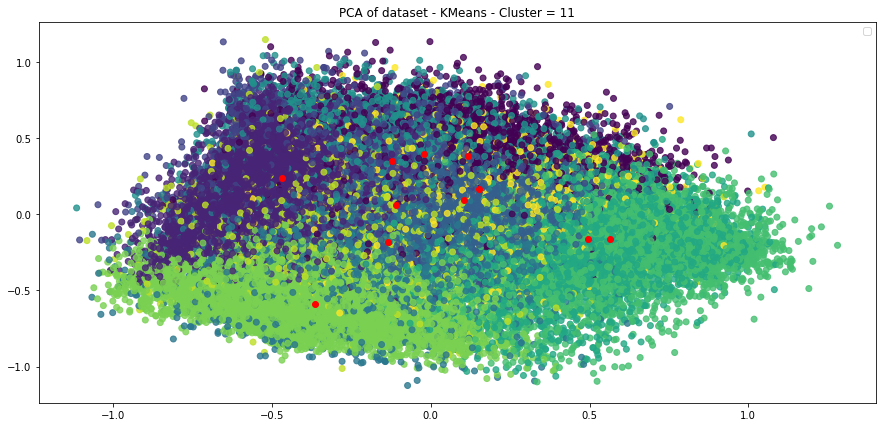

In [150]:
# Plot what looks like the clusterisation
PCA_Visualisation(norm_clients_data,
                  kmeans_cluster, 
                  [list(dic.values()) for dic in kmeans_centers],
                  method = 'KMeans',
                  threeD = threeD)

In [151]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~4741secondes


# HIERARCHICAL CLUSTERING

In [24]:
if do_Analysis:
    Analysis(norm_clients_data.head(max_fitted),
             treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax, 
             method = 'ward', Algo= 'hierarchical')

In [25]:
# Run Hierarchical Clustering model
start  = time()

hierarchical_model = AgglomerativeClustering(n_clusters=K, affinity='euclidean', linkage=method)  
hierarchical_model.fit(norm_clients_data.head(max_fitted))
print(hierarchical_model)
# 15s * (N/10k)²
print("Time Taken to fit/predict model : ~" + str(int(time() - start)) + "secondes")

AgglomerativeClustering(n_clusters=15)
Time Taken to fit/predict model : ~6secondes


In [26]:
start = time()

# Get the cluster labels and the cluster centers of the model
hierarchical_cluster  = hierarchical_model.labels_
hierarchical_centroid = get_centroid(norm_clients_data, hierarchical_cluster)

#Get the interest of each cluster and plot it
hierarchical_interest = get_interest(hierarchical_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh)
print_interest(conn, hierarchical_interest, hierarchical_cluster, list(hierarchical_centroid))

# environ 30s
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 7.77 %
 Univ_KEY         Univ_1                       Univ_2  Power
      402  PRET A MANGER               PLATS PREPARES   0.36
      147        DESSERT                   PATISSERIE   0.34
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   0.32


Cluster 1: 24.96 %
 Univ_KEY        Univ_1         Univ_2  Power
      402 PRET A MANGER PLATS PREPARES   0.98


Cluster 2: 9.44 %
 Univ_KEY        Univ_1      Univ_2  Power
      362 PRET A MANGER  SANDWICHES   0.83
      228      BOISSONS SOFT DRINKS   0.43


Cluster 3: 12.06 %
 Univ_KEY         Univ_1                       Univ_2  Power
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   0.96
      402  PRET A MANGER               PLATS PREPARES   0.34


Cluster 4: 9.95 %
 Univ_KEY         Univ_1                       Univ_2  Power
      299 PETIT DEJEUNER                 VIENNOISERIE   0.92
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   0.36
      402  PRET A MANGER               PLATS PREPARES   0.33


Clus

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.12681777 0.09760867]
Time Taken to show PCA : ~0secondes


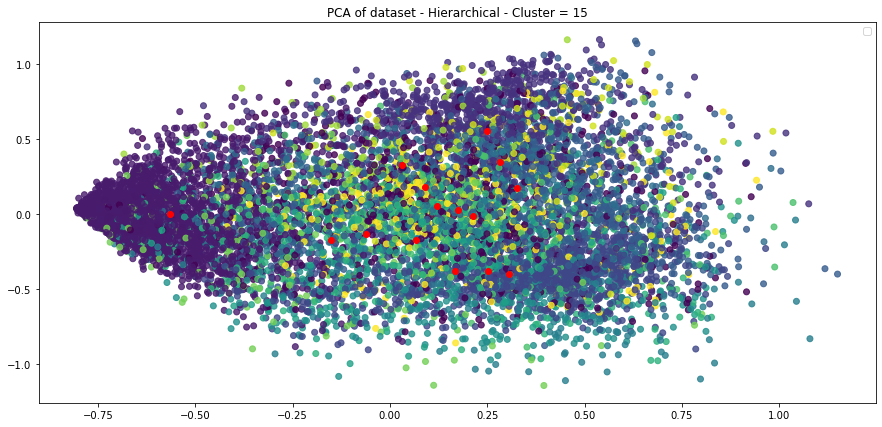

In [27]:
# Plot what looks like the clusterisation
PCA_Visualisation(norm_clients_data.head(max_fitted), 
                  hierarchical_cluster,
                  [list(dic.values()) for dic in hierarchical_centroid],
                  method = 'Hierarchical',
                  threeD = threeD)

In [28]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~730secondes


## PCA Dimension reductor + KMeans

In [29]:
if do_Analysis:
    PCA_Analysis(norm_clients_data)

In [30]:
# Reduce the dimension of the Data
model_pca = PCA(n_components= nbr_dim_keep)
new_datas = model_pca.fit(norm_clients_data).transform(norm_clients_data)

new_datas = pd.DataFrame(index=norm_clients_data.index, data = new_datas)
print(new_datas)

               0         1         2         3         4         5         6  \
130250  0.085715 -0.586307  0.212008 -0.132149  0.007133 -0.523296 -0.293034   
25255   0.242761  0.237544  0.814342 -0.043212  0.241436 -0.117028  0.069826   
155963 -0.217106  0.171609  0.325241  0.337042  0.161602 -0.417582 -0.093845   
149192  0.335948 -0.336411 -0.649034 -0.068702  0.744778  0.014744 -0.065146   
84426  -0.202470 -0.151056  0.684135  0.243158  0.609563 -0.417447 -0.076418   
...          ...       ...       ...       ...       ...       ...       ...   
98403  -0.070236  0.447095  0.215153 -0.170047  0.466589  0.334312 -0.056328   
104073 -0.757173 -0.024196 -0.295542 -0.122565  0.105000 -0.100065  0.064284   
102476 -0.558827  0.048725 -0.158088  0.129470  0.121472 -0.063024 -0.073692   
74979  -0.292136  0.017837  0.036215 -0.450149  0.128418 -0.117716  0.739528   
125857 -0.492613  0.178054  0.050138  0.139752  0.346558  0.019012  0.116188   

               7         8         9  


In [31]:
if do_Analysis:
    Analysis(new_datas, treshold = Standard_Tresh if Standard_Norm else MinMax_Tesh, Kmin = Kmin, Kmax = Kmax)

In [32]:
# Run KMeans model on data reduced
start = time()

model = KMeans(K_PCA, n_init = n_init)
model.fit(new_datas)

# environ 1min
print("Time Taken to fit model : ~" + str(int(time() - start)) + "secondes")

Time Taken to fit model : ~87secondes


In [33]:
start = time()

# Get the cluster labels and the cluster centers of the model
PCA_cluster  = model.labels_
PCA_centroid = get_centroid(norm_clients_data, PCA_cluster)        
  
#Get the interest of each cluster and plot it     
PCA_interest = get_interest(PCA_centroid, 
                       Standard_Tresh if Standard_Norm else MinMax_Tesh)
print_interest(conn, PCA_interest, PCA_cluster, PCA_centroid)

#environ 3min
print("Time Taken to get interests : ~" + str(int(time() - start)) + "secondes")



Cluster 0: 19.85 %
 Univ_KEY        Univ_1         Univ_2  Power
      402 PRET A MANGER PLATS PREPARES   0.99


Cluster 1: 9.81 %
 Univ_KEY         Univ_1                       Univ_2  Power
      294 PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   0.98


Cluster 2: 6.83 %
 Univ_KEY        Univ_1     Univ_2  Power
      362 PRET A MANGER SANDWICHES   0.98


Cluster 3: 4.43 %
 Univ_KEY                     Univ_1                       Univ_2  Power
      294             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS   0.71
      402              PRET A MANGER               PLATS PREPARES   0.65
      228                   BOISSONS                  SOFT DRINKS   0.60
      299             PETIT DEJEUNER                 VIENNOISERIE   0.44
      319 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS   0.44
       51            PRET A CUISINER                      FROMAGE   0.37
      362              PRET A MANGER                   SANDWICHES   0.35


Cluster 4: 6.94 %
 Univ_KEY        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.12697742 0.09872707]
Time Taken to show PCA : ~0secondes


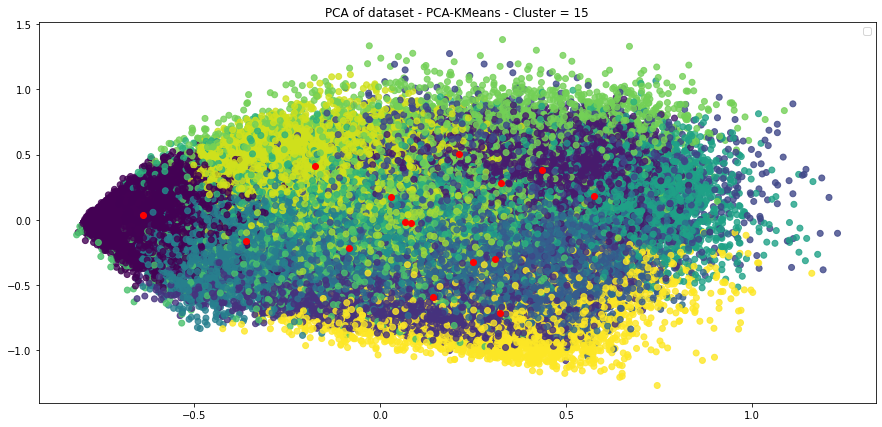

In [34]:
# Plot what looks like the clusterisation
PCA_Visualisation(norm_clients_data, 
                  PCA_cluster, 
                  [list(dic.values()) for dic in PCA_centroid],
                  method = 'PCA-KMeans',
                  threeD = threeD)

In [35]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~869secondes


## Reconstruction des résultats du KMeans A LA MAIN

In [152]:
"""
    Afin d'obtenir une meilleur clusterisation, une patte humaine est nécessaire.
    Cette partie permet de regrouper certains cluster que l'on peut juger trop similaire afin de diminuer le nombre de segment finaux.
    Plusieurs variable sont ainsi accessible ci-dessous, seul la dernière à réellement de l'importance.
    Les autres ne servent qu'à mieux plot, mieux cerner les intéret, ...
    
    La variable cluster_correspondance associe à chaque cluser un autre cluster, un relation N->1.
    Les clés sont les clusters actuelle, les valeurs seront les nouveaux cluster.
    Deux cluster ayant la même valeur seront regroupé entre eux en un même cluster.
    
    Il est fortement conseillé de passer par cette courte étape pour obtenir une segmentation obtimale.
"""

algo            = "KMeans"
cluster         = kmeans_cluster
cluster_centers = kmeans_centers
tresh           = Standard_Tresh/2 if Standard_Norm else MinMax_Tesh/2

cluster_correspondance = {i:i for i in range(K)}

In [153]:
start = time()
new_K = len(set(cluster_correspondance.values()))

# Get new labels of the custommer
new_cluster = []
for c in cluster:
    new_cluster.append(cluster_correspondance[c])
new_cluster =  np.array(new_cluster)
    
# Get new center of the cluster
new_cluster_center = get_centroid(norm_clients_data, new_cluster)   

#environ 2min
print("Time Taken to change clusters: ~" + str(int(time() - start)) + "secondes")

Time Taken to change clusters: ~142secondes


In [154]:
tresh = .15

# Get new interest of the cluster
new_interest = get_interest(new_cluster_center, tresh)

NACK = print_interest(conn, new_interest, new_cluster, new_cluster_center)   




Cluster 0: 6.35 %
 Univ_KEY                     Univ_1                       Univ_2         Univ_3  Power
      180           FRUITS   LEGUMES                      LEGUMES AUTRES LEGUMES   0.80
      322 APERITIF   ENTREES   TAPAS    BISCUITERIE SALEE  SNACKS          CHIPS   0.25
      297             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS          PAINS   0.22
      171           FRUITS   LEGUMES                       FRUITS       EXOTIQUE   0.21
      294             PETIT DEJEUNER BOULANGERIE   PROD CROQUANTS      BAGUETTES   0.19
       13            PRET A CUISINER                4 ET 5  GAMME        SALADES   0.18
      299             PETIT DEJEUNER                 VIENNOISERIE  VIENNOISERIES   0.18
       61            PRET A CUISINER                  CHARCUTERIE        JAMBONS   0.17
      228                   BOISSONS                  SOFT DRINKS           SODA   0.17


Cluster 1: 13.72 %
 Univ_KEY         Univ_1                       Univ_2            Univ_3  Power


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Explained variance ratio from PCA: [0.07125183 0.06087146]
Time Taken to show PCA : ~0secondes


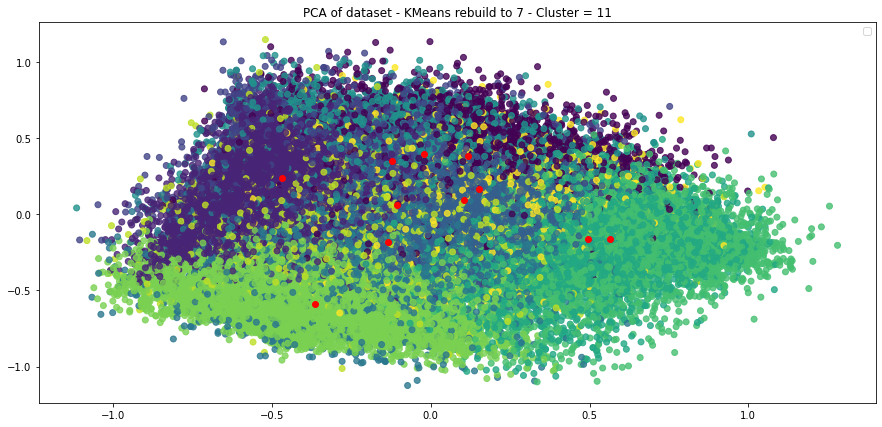

In [155]:
# Plot what looks like the clusterisation
PCA_Visualisation(norm_clients_data, 
                  new_cluster, 
                  [list(dic.values()) for dic in new_cluster_center], 
                  method = 'KMeans rebuild to 7', 
                  threeD = threeD)

In [156]:
print("Total Time Taken: ~" + str(int(time() - Very_Start)) + "secondes") 

Total Time Taken: ~4968secondes


## INSERT INTO TABLE

In [157]:
"""
    Définition de tous les paramètres, tables et engines permettant l'insert de données.
    Les table de la DB auront le format : [DB_INSERT].[schema_INSERT].[TABLE_NAME]
"""
driver   = '{ODBC Driver 17 for SQL Server}'
server   = 'E5591-9S6YMV2'
username = 'WVN\k.dubrulle'
login    = ('DRIVER=' + driver + 
         ';SERVER='   + server + 
         ';Trusted_Connection=yes;')

DB_INSERT     = "DelitraiteurBI_ResultML"

schema_INSERT = "PML"

TABLE_PARAMS    = "UC2_Caracteristique"    
TABLE_SEGMENT   = "UC2_Segment"   
TABLE_S_CONTENT = "UC2_Segment_Content"  
TABLE_S_CLIENT  = "UC2_Segment_Client"

params        = urllib.parse.quote_plus(login)
engine_INSERT = create_engine("mssql+pyodbc:///?odbc_connect=%s" % params)

In [158]:
# TEST Connexion
conn = engine_INSERT.connect()

df = pd.read_sql("SELECT TOP(10) ["+TABLE_UNIVERS+".KEY] FROM ["+DB_INSERT+"].[DWH].[Dim_"+TABLE_UNIVERS+"]", conn)
print(df)

conn.close()

   Univers.KEY
0           -1
1            1
2            2
3            3
4            4
5            5
6            6
7            7
8            8
9            9


In [159]:
now = date.today()
sql_cmd = '''
INSERT INTO ['''+DB_INSERT+'''].['''+schema_INSERT+'''].['''+TABLE_PARAMS+''']
     VALUES
           ('''+str(now.year*10000 + now.month*100 + now.day)+'''
           ,'''+"'"+str(DB)+"'"+'''
           ,'''+str(Univers_Depth)+'''
           ,'''+str(int(take_fidelity))+'''
           ,'''+str(year)+'''
           ,'''+str(K if algo != "PCA" else K_PCA)+'''
           ,'''+str(new_K)+'''
           ,'''+str(NACK)+'''
           ,'''+"'"+algo+"'"+'''
           ,'''+str(client_tresh)+'''
           ,'''+str(univers_tresh)+'''
           ,'''+"'"+("Standard" if Standard_Norm else "MinMax")+"'"+'''
           ,'''+str(tresh)+'''
           ,'''+("Null" if algo != "PCA" else nbr_dim_keep)+'''
           ,'''+("Null" if algo != "hierarchical" else method)+''')
'''

print(sql_cmd)

conn = engine_INSERT.connect()
conn.execute(sql_cmd)

# Recuperation of primary key of TABLE_PARAMS last elements 
params_key = pd.read_sql("SELECT ["+TABLE_PARAMS+".KEY] FROM ["
                         +DB_INSERT+"].["+schema_INSERT+"].["+TABLE_PARAMS+"] ORDER BY 1 DESC",
                             conn).values[0][0]
    
conn.close()


INSERT INTO [DelitraiteurBI_ResultML].[PML].[UC2_Caracteristique]
     VALUES
           (20220816
           ,'Export Data Prod'
           ,3
           ,0
           ,2020
           ,11
           ,11
           ,0
           ,'KMeans'
           ,10
           ,50
           ,'MinMax'
           ,0.15
           ,Null
           ,Null)



In [160]:
conn = engine_INSERT.connect()
for key in range(new_K):
    proportion = round(new_cluster.tolist().count(key)*100/len(new_cluster),2)
    is_NACK    = not bool(len(new_interest[key]))
    sql_cmd = '''
    INSERT INTO ['''+DB_INSERT+'''].['''+schema_INSERT+'''].['''+TABLE_SEGMENT+''']
         VALUES
               ('''+str(params_key)+'''
               ,'''+str(int(is_NACK))+'''
               ,'''+str(key)+'''
               ,'''+str(proportion)+'''
               ,NULL)
    '''
#     print(sql_cmd)
    conn.execute(sql_cmd)
    
    
    segment_key = pd.read_sql("SELECT ["+TABLE_SEGMENT+".KEY] FROM ["
                         +DB_INSERT+"].["+schema_INSERT+"].["+TABLE_SEGMENT+"] ORDER BY 1 DESC",
                             conn).values[0][0]
    
    if take_fidelity:
        sql_cmd = "INSERT INTO ["+DB_INSERT+"].["+schema_INSERT+"].["+TABLE_S_CLIENT+"] VALUES "
        counter = 0
        for i in range(len(new_cluster)):
            if new_cluster[i] == key:
                sql_cmd += " ("+str(norm_clients_data.index[i])+","+str(segment_key)+"),"
                counter += 1
                
            if counter > 900:
                sql_cmd = sql_cmd[:-1] + ';'
                conn.execute(sql_cmd)
                sql_cmd = "INSERT INTO ["+DB_INSERT+"].["+schema_INSERT+"].["+TABLE_S_CLIENT+"] VALUES "
                counter = 0
        if counter:
            sql_cmd = sql_cmd[:-1] + ';'
            conn.execute(sql_cmd)
    
    for univ in new_interest[key]:
        sql_cmd = '''
        INSERT INTO ['''+DB_INSERT+'''].['''+schema_INSERT+'''].['''+TABLE_S_CONTENT+''']
             VALUES
                   ('''+str(segment_key)+'''
                   ,'''+str(univ)+'''
                   ,'''+str(round(new_cluster_center[key][univ],2))+''')'''
#         print(sql_cmd)
        conn.execute(sql_cmd)
conn.close()